##Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModel
import torch
from tqdm.auto import tqdm
import ast
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

##**Cargar archivos**

Tras cargar los archivos que estan en la carpet ade drive, se corrige un error que se ha encontrado. Algunas frases contienen comas en medio, que no pertenecen a la separación por columnas. Esto se soluciona en principio poniendo comillas, pero no en todos los casos es así, por lo que se intenta solucionar para que se pueda tener la información de todas las filas correctamente. También hemos descubierto algunos sentimientos con distintos formatos, por lo que normalizamos para que solo halla tres y lo ponenmos en una columna nueva. Finalmente lo juntamos todo en un solo archivo.

In [ ]:

drive.mount('/content/drive')

# Configurar directorios
BASE_DIR = "/content/drive/Shareddrives/NLP"
TEXT_DIR = os.path.join(BASE_DIR, "chunks_conTags")

# Cargar archivos TXT correctamente
archivos = [f for f in os.listdir(TEXT_DIR) if f.endswith('.txt')]
print(f"Encontrados {len(archivos)} archivos TXT")

def cargar_archivo_txt_corregido(ruta_archivo):
    """Cargar archivo TXT conservando los sentimientos originales"""
    datos = []

    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        lineas = f.readlines()

    # Saltar el encabezado si existe
    start_idx = 0
    if lineas[0].startswith('video_id,chunk_id,text,sentimiento'):
        start_idx = 1

    for i, linea in enumerate(lineas[start_idx:], start_idx):
        linea = linea.strip()
        if not linea:
            continue

        try:
            # Método más robusto: dividir por comas y reconstruir
            partes = linea.split(',')

            if len(partes) >= 4:
                video_id = partes[0]
                chunk_id = partes[1]

                # Reconstruir el texto (puede contener comas)
                # El texto está entre las posiciones 2 y -2, el sentimiento en la última
                texto = ','.join(partes[2:-1]).strip()
                sentimiento = partes[-1].strip()

                # Limpiar comillas del texto si las tiene
                if texto.startswith('"') and texto.endswith('"'):
                    texto = texto[1:-1]

                datos.append({
                    'video_id': video_id,
                    'chunk_id': chunk_id,
                    'text': texto,
                    'sentimiento': sentimiento
                })

        except Exception as e:
            print(f"Error en línea {i}: {linea}")
            print(f"Error: {e}")
            continue

    return pd.DataFrame(datos)

# Cargar y combinar datos corregidos
dataframes = []
for archivo in archivos:
    file_path = os.path.join(TEXT_DIR, archivo)
    print(f"Cargando: {archivo}")

    try:
        df_temp = cargar_archivo_txt_corregido(file_path)
        print(f"  Forma: {df_temp.shape}")
        dataframes.append(df_temp)
    except Exception as e:
        print(f"  Error cargando {archivo}: {e}")

# Combinar todos los datos
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    print(f"\nDataset combinado: {df.shape}")

    # NORMALIZAR SENTIMIENTOS EXISTENTES A MINÚSCULAS
    def normalizar_sentimiento(sentimiento):
        if pd.isna(sentimiento):
            return None
        sentimiento_str = str(sentimiento).strip().lower()

        # Mapear variaciones a los valores estándar
        if sentimiento_str in ['pos', 'positivo', 'positive', 'positivity']:
            return 'positivo'
        elif sentimiento_str in ['neg', 'negativo', 'negative', 'negatividad']:
            return 'negativo'
        elif sentimiento_str in ['neu', 'neutro', 'neutral', 'neuter']:
            return 'neutro'
        else:
            # Si no es reconocible, devolver None para que sea analizado
            return None

    print("Normalizando sentimientos existentes a minúsculas...")
    df['sentimiento_normalizado'] = df['sentimiento'].apply(normalizar_sentimiento)

    print("Columnas:", df.columns.tolist())
    print("\nPrimeras filas:")
    print(df.head())
    print(f"\nTipos de datos:")
    print(df.dtypes)

    # Verificar la distribución de sentimientos
    print(f"\nDistribución de sentimientos ORIGINALES:")
    print(df['sentimiento'].value_counts())

    print(f"\nDistribución de sentimientos NORMALIZADOS:")
    print(df['sentimiento_normalizado'].value_counts())

else:
    print("No se pudieron cargar archivos")

output_path = os.path.join(BASE_DIR, "dataset_sentimientos_normalizados.csv")
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\nDataset guardado en: {output_path}")

Mounted at /content/drive
Encontrados 40 archivos TXT
Cargando: INTELIGENCIA ARTIFICIAL_ prepararse para su LLEGADA_conTags.txt
  Forma: (234, 4)
Cargando: Por que SI HAY QUE HABLAR DE POLITICA en el APAGON_conTags.txt
  Forma: (305, 4)
Cargando: Ingeniero de REDES ELECTRICAS HABLA sobre el APAGON_conTags.txt
  Forma: (465, 4)
Cargando: CARCEL por PROTESTAR(con Francho AIJON)_conTags.txt
  Forma: (395, 4)
Cargando: CAYENDO por su propo Peso_conTags.txt
  Forma: (225, 4)
Cargando: ENVIA BUQUES de GUERRA y DESTRUCTORES a VENEZUELA_conTags.txt
  Forma: (105, 4)
Cargando: Situacion INSOSTENIBLE en GAZA_conTags.txt
  Forma: (214, 4)
Cargando: El SINTOMA de un ENORME PROBLEMA POLITICO_conTags.txt
  Forma: (268, 4)
Cargando: ARANCELES_ TRUMP REVIENTA SU PROPIA BOLSA_conTags.txt
  Forma: (270, 4)
Cargando: RETIRADA en el PRIMER ASALTO_conTags.txt
  Forma: (180, 4)
Cargando: Lucha IDEOLOGICA en el VATICANO_conTags.txt
  Forma: (177, 4)
Cargando: Republicanismo contra el AUTORITARISMO que VIENE_

##**Shallow learning**

Se codifican las labels y se divide el dataset en train y test con stratify. Aplicamos TF-IDF, definimos los modelos de logistic regression, Naive Bayes y SVM para entrenarlos y evaluarlos con el accuracy y la cross-validation. Después se muestran los resultados y se comparan. Además, se miran ejemplos de frases nuestras y nuevas frases.

📊 Dataset cargado exitosamente
Clases únicas en el target: ['positivo' 'negativo' 'neutro' nan]
Tipo de datos del target: object

 Clases codificadas: {'nan': np.int64(0), 'negativo': np.int64(1), 'neutro': np.int64(2), 'positivo': np.int64(3)}
Tipo de clases: [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]

 División de datos:
Train: 10698 muestras
Test: 2675 muestras

 Aplicando TF-IDF...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

Dimensiones TF-IDF Train: (10698, 5000)
Dimensiones TF-IDF Test: (2675, 5000)

 Entrenando y evaluando modelos...

--- Entrenando Logistic Regression ---
Accuracy: 0.7039
Cross-val Accuracy: 0.7098 (+/- 0.0053)

--- Entrenando Naive Bayes ---
Accuracy: 0.6793
Cross-val Accuracy: 0.6937 (+/- 0.0066)

--- Entrenando SVM ---
Accuracy: 0.6864
Cross-val Accuracy: 0.6979 (+/- 0.0145)

 RESULTADOS COMPARATIVOS
                Modelo  Accuracy   CV Mean    CV Std
0  Logistic Regression  0.703925  0.709758  0.002638
2                  SVM  0.686355  0.697886  0.007228
1          Naive Bayes  0.679252  0.693681  0.003314

 MEJOR MODELO: Logistic Regression con accuracy: 0.7039

 REPORTE DEL MEJOR MODELO:
              precision    recall  f1-score   support

         nan       1.00      0.03      0.05        37
    negativo       0.60      0.28      0.38       630
      neutro       0.72      0.94      0.81      1800
    positivo       0.50      0.06      0.10       208

    accuracy            

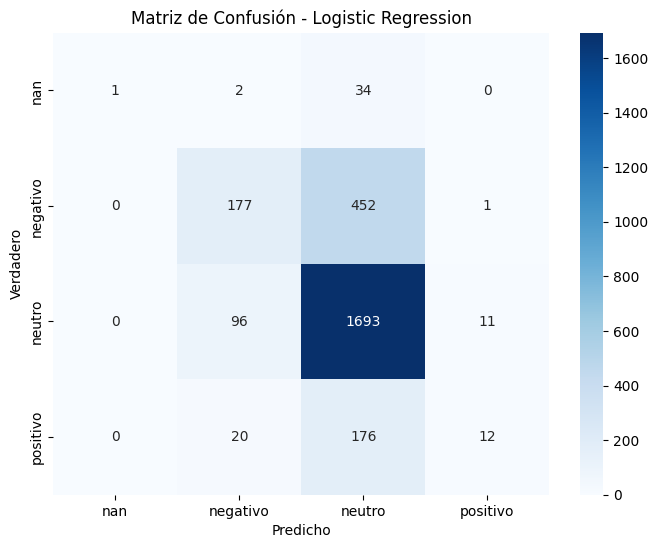


 DISTRIBUCIÓN DE CLASES:
sentimiento_normalizado
neutro      8998
negativo    3148
positivo    1043
nan          184
Name: count, dtype: int64

 EJEMPLO DE PREDICCIONES DEL CONJUNTO DE TEST:

Texto: 'No, hombre, no.'
 Verdadero: neutro | Predicho: neutro

Texto: 'Yo creo que lo que hay que hacer es esperar a ver lo que este chico, este asesino, este asesino, est...'
 Verdadero: neutro | Predicho: neutro

Texto: '¿Estamos qué tipo de convenios hemos hecho con Burkina Faso y el capitán Ibrahintraore, por ejemplo?'
 Verdadero: neutro | Predicho: neutro

Texto: 'En los sitios donde sí que los echaros, las condiciones laborales y las condiciones vitales mejoraro...'
 Verdadero: negativo | Predicho: negativo

Texto: 'Recordimos que esto siempre se ha entendido muy bien con el Partido Socialista, ¿no?'
 Verdadero: neutro | Predicho: negativo

 PRUEBA DE PREDICCIÓN CON NUEVO TEXTO:

Texto: 'Me encanta este contenido, es muy educativo y entretenido'
Sentimiento predicho: neutro
Probabilidad na

In [ ]:

nltk.download('stopwords', quiet=True)
stop_words_es = list(set(stopwords.words('spanish')))

# Configuración para visualizaciones
plt.style.use('default')
sns.set_palette("husl")

# Cargar el dataset
BASE_DIR = "/content/drive/Shareddrives/NLP"
dataset_path = os.path.join(BASE_DIR, "dataset_sentimientos_normalizados.csv")
df = pd.read_csv(dataset_path, encoding='utf-8')
print("📊 Dataset cargado exitosamente")

# Verificar las clases únicas en el target
print(f"Clases únicas en el target: {df['sentimiento_normalizado'].unique()}")
print(f"Tipo de datos del target: {df['sentimiento_normalizado'].dtype}")

# Preparar features y target
X = df['text']
y = df['sentimiento_normalizado']

# Asegurarnos de que las etiquetas sean strings
y = y.astype(str)

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n Clases codificadas: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Tipo de clases: {[type(c) for c in label_encoder.classes_]}")

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n División de datos:")
print(f"Train: {X_train.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

# Aplicar TF-IDF
print("\n Aplicando TF-IDF...")

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words=stop_words_es,
    min_df=2,
    max_df=0.8,
    lowercase=True,
    strip_accents='unicode'
)

# Ajustar y transformar los datos
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Dimensiones TF-IDF Train: {X_train_tfidf.shape}")
print(f"Dimensiones TF-IDF Test: {X_test_tfidf.shape}")

# Definir modelos a probar
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(random_state=42)
}

# Entrenar y evaluar modelos
print("\n Entrenando y evaluando modelos...")

results = {}
best_model_name = None
best_accuracy = 0
best_predictions = None
best_model_obj = None

for name, model in models.items():
    print(f"\n--- Entrenando {name} ---")

    # Entrenar modelo
    model.fit(X_train_tfidf, y_train)

    # Predecir
    y_pred = model.predict(X_test_tfidf)

    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-val Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Guardar resultados
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }

    # Actualizar mejor modelo
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_predictions = y_pred
        best_model_obj = model

# Mostrar resultados comparativos
print("\n" + "="*50)
print(" RESULTADOS COMPARATIVOS")
print("="*50)

results_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'CV Mean': [results[name]['cv_mean'] for name in results],
    'CV Std': [results[name]['cv_std'] for name in results]
}).sort_values('Accuracy', ascending=False)

print(results_df)

print(f"\n MEJOR MODELO: {best_model_name} con accuracy: {best_accuracy:.4f}")

# CORREGIDO: Asegurarnos de que los target_names sean strings
print("\n REPORTE DEL MEJOR MODELO:")
print("="*30)

# Convertir las clases a strings para evitar el error
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, best_predictions, target_names=target_names))

# Matriz de confusión del mejor modelo
print("\n MATRIZ DE CONFUSIÓN:")
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# También mostrar distribución de clases
print("\n DISTRIBUCIÓN DE CLASES:")
class_distribution = pd.Series(y).value_counts()
print(class_distribution)

# Ejemplo de predicciones en nuevos textos
print("\n EJEMPLO DE PREDICCIONES DEL CONJUNTO DE TEST:")
print("="*45)

# Seleccionar algunos ejemplos del test
sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)

for idx in sample_indices:
    original_text = X_test.iloc[idx]
    true_label_encoded = y_test[idx]
    pred_label_encoded = best_predictions[idx]

    true_label = label_encoder.inverse_transform([true_label_encoded])[0]
    pred_label = label_encoder.inverse_transform([pred_label_encoded])[0]

    print(f"\nTexto: '{original_text[:100]}{'...' if len(original_text) > 100 else ''}'")
    if true_label == pred_label:
        print(f" Verdadero: {true_label} | Predicho: {pred_label}")
    else:
        print(f" Verdadero: {true_label} | Predicho: {pred_label}")

# Función para predecir nuevos textos - MEJORADA
def predecir_sentimiento(texto, modelo=best_model_obj, tfidf_vectorizer=tfidf, encoder=label_encoder):
    """
    Función para predecir sentimiento de nuevos textos
    """
    # Transformar el texto
    texto_tfidf = tfidf_vectorizer.transform([texto])

    # Predecir
    prediccion_encoded = modelo.predict(texto_tfidf)[0]
    prediccion = encoder.inverse_transform([prediccion_encoded])[0]

    # Obtener probabilidades o scores
    if hasattr(modelo, 'predict_proba'):
        probabilidades = modelo.predict_proba(texto_tfidf)[0]
    elif hasattr(modelo, 'decision_function'):
        # Para SVM y otros modelos sin predict_proba
        decision_scores = modelo.decision_function(texto_tfidf)
        # Normalizar a probabilidades
        from scipy.special import softmax
        probabilidades = softmax(decision_scores)[0]
    else:
        probabilidades = None

    resultado = {
        'texto': texto,
        'sentimiento_predicho': prediccion,
        'probabilidades': probabilidades
    }

    if probabilidades is not None:
        for clase, prob in zip(encoder.classes_, probabilidades):
            resultado[f'prob_{clase}'] = float(prob)  # Convertir a float nativo de Python

    return resultado

# Ejemplo de uso de la función de predicción
print("\n PRUEBA DE PREDICCIÓN CON NUEVO TEXTO:")
print("="*40)

textos_ejemplo = [
    "Me encanta este contenido, es muy educativo y entretenido",
    "No me gusta para nada, es aburrido y malo",
    "Está bien, pero podría mejorar en algunos aspectos"
]

for texto in textos_ejemplo:
    resultado = predecir_sentimiento(texto)
    print(f"\nTexto: '{resultado['texto']}'")
    print(f"Sentimiento predicho: {resultado['sentimiento_predicho']}")

    if resultado['probabilidades'] is not None:
        for clase in label_encoder.classes_:
            prob_key = f'prob_{clase}'
            if prob_key in resultado:
                print(f"Probabilidad {clase}: {resultado[prob_key]:.4f}")

print("\n Proceso completado exitosamente!")

#**Deep Learning**

Embeddings

Creamos embeddings de dos tipos. Uno congelado y uno fine-tuneado. Se entrenan modelos con estos embeddings y se guardan en una carpeta.

In [ ]:

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Usando dispositivo: {device}")

# Cargar el dataset
BASE_DIR = "/content/drive/Shareddrives/NLP"
dataset_path = os.path.join(BASE_DIR, "dataset_sentimientos_normalizados.csv")
df = pd.read_csv(output_path, encoding='utf-8')
print(" Dataset cargado exitosamente")
print(f"Tamaño del dataset: {len(df)}")

# Verificar los valores únicos en la columna de sentimiento
print("Valores únicos en sentimiento_normalizado:")
print(df['sentimiento_normalizado'].value_counts())
print(f"Valores nulos en sentimiento_normalizado: {df['sentimiento_normalizado'].isnull().sum()}")

# Limpiar y preparar los datos
print("\n Limpiando y preparando datos...")

# Eliminar filas con valores nulos en texto o sentimiento
df = df.dropna(subset=['text', 'sentimiento_normalizado'])
print(f"Tamaño después de eliminar nulos: {len(df)}")

# Convertir a string y limpiar espacios
df['sentimiento_normalizado'] = df['sentimiento_normalizado'].astype(str).str.strip().str.lower()

# Verificar los valores únicos después de la limpieza
unique_sentiments = df['sentimiento_normalizado'].unique()
print(f"Valores únicos después de limpieza: {unique_sentiments}")

# Crear el mapeo de etiquetas dinámicamente
label_map = {}
for sentiment in unique_sentiments:
    if 'negativo' in sentiment.lower():
        label_map[sentiment] = 0
    elif 'positivo' in sentiment.lower():
        label_map[sentiment] = 2
    elif 'neutro' in sentiment.lower() or sentiment == '0':
        label_map[sentiment] = 1
    else:
        # Para valores no reconocidos, asignar neutral por defecto
        label_map[sentiment] = 1

print(f"Label map creado: {label_map}")

# Aplicar el mapeo
df['label'] = df['sentimiento_normalizado'].map(label_map)

# Verificar si hay NaN después del mapeo
nan_count = df['label'].isnull().sum()
print(f"Valores NaN después del mapeo: {nan_count}")

# Si todavía hay NaN, llenarlos con un valor por defecto (neutro)
if nan_count > 0:
    print("  Hay valores no mapeados. Asignando valor neutro por defecto...")
    df['label'] = df['label'].fillna(1)

# Verificar la distribución final
print("\n Distribución final de etiquetas:")
print(df['label'].value_counts().sort_index())
print(f"Valores únicos en label: {df['label'].unique()}")

# Dividir el dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"\n Conjunto de entrenamiento: {len(train_df)}")
print(f" Conjunto de validación: {len(val_df)}")
print(f" Conjunto de prueba: {len(test_df)}")

# Dataset personalizado
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])  # Asegurar que sea int

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Modelo con embeddings congelados (NO fine-tuned)
class BERTFrozenClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout_rate=0.3):
        super(BERTFrozenClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)

        # Congelar parámetros de BERT
        for param in self.bert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

# Modelo con embeddings fine-tuned
class BERTFineTunedClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout_rate=0.3):
        super(BERTFineTunedClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.classifier(output)

# Función de entrenamiento
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, model_name):
    model.to(device)
    train_losses = []
    val_accuracies = []

    best_val_accuracy = 0
    best_model_state = None

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validación
        model.eval()
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                _, predicted = torch.max(outputs, 1)

                val_predictions.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        val_accuracy = accuracy_score(val_true, val_predictions)

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)

        print(f'{model_name} - Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Validation accuracy: {val_accuracy:.4f}')

        # Guardar el mejor modelo
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()

    # Cargar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_accuracies

# Configuración principal
BERT_MODEL = "dccuchile/bert-base-spanish-wwm-uncased"
NUM_CLASSES = 3
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

# Inicializar tokenizer
print("\n Cargando tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

# Crear datasets y dataloaders
print(" Creando datasets y DataLoaders...")
train_dataset = SentimentDataset(train_df['text'], train_df['label'], tokenizer)
val_dataset = SentimentDataset(val_df['text'], val_df['label'], tokenizer)
test_dataset = SentimentDataset(test_df['text'], test_df['label'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(" Datasets y DataLoaders creados exitosamente")

# Entrenar modelo con embeddings congelados
print("\n" + "="*50)
print(" ENTRENANDO MODELO CON EMBEDDINGS CONGELADOS")
print("="*50)

frozen_model = BERTFrozenClassifier(BERT_MODEL, NUM_CLASSES)
frozen_optimizer = AdamW(frozen_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

frozen_model, frozen_train_losses, frozen_val_accuracies = train_model(
    frozen_model, train_loader, val_loader, frozen_optimizer, criterion, EPOCHS, "Frozen BERT"
)

# Entrenar modelo con embeddings fine-tuned
print("\n" + "="*50)
print(" ENTRENANDO MODELO CON EMBEDDINGS FINE-TUNED")
print("="*50)

finetuned_model = BERTFineTunedClassifier(BERT_MODEL, NUM_CLASSES)
finetuned_optimizer = AdamW(finetuned_model.parameters(), lr=LEARNING_RATE)

finetuned_model, finetuned_train_losses, finetuned_val_accuracies = train_model(
    finetuned_model, train_loader, val_loader, finetuned_optimizer, criterion, EPOCHS, "Fine-tuned BERT"
)

# Evaluación en el conjunto de prueba
def evaluate_model(model, test_loader, model_name):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"\n {model_name} - Resultados en prueba:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(true_labels, predictions,
                              target_names=['negativo', 'neutro', 'positivo']))

    return accuracy, predictions, true_labels

# Evaluar ambos modelos
print("\n" + "="*50)
print(" EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA")
print("="*50)

frozen_accuracy, frozen_preds, frozen_true = evaluate_model(frozen_model, test_loader, "BERT Congelado")
finetuned_accuracy, finetuned_preds, finetuned_true = evaluate_model(finetuned_model, test_loader, "BERT Fine-tuned")

# Comparación final
print("\n" + "="*50)
print(" COMPARACIÓN FINAL")
print("="*50)
print(f" BERT con embeddings congelados - Accuracy: {frozen_accuracy:.4f}")
print(f" BERT con embeddings fine-tuned - Accuracy: {finetuned_accuracy:.4f}")
print(f" Diferencia: {finetuned_accuracy - frozen_accuracy:.4f}")

# Función para predecir nuevos textos
def predict_sentiment(text, model, tokenizer):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()

    sentiment_map = {0: 'negativo', 1: 'neutro', 2: 'positivo'}
    return sentiment_map[predicted_class], probabilities.cpu().numpy()[0]

# Ejemplo de predicción
print("\n" + "="*50)
print(" PREDICCIÓN DE EJEMPLO")
print("="*50)

sample_texts = [
    "Me encanta este producto, es increíble",
    "No me gusta para nada, es terrible",
    "Está bien, ni fu ni fa",
    "Es aceptable pero podría mejorar",
    "Odio cuando las cosas no funcionan como deberían"
]

for i, text in enumerate(sample_texts, 1):
    frozen_sentiment, frozen_probs = predict_sentiment(text, frozen_model, tokenizer)
    finetuned_sentiment, finetuned_probs = predict_sentiment(text, finetuned_model, tokenizer)

    print(f"\nEjemplo {i}:")
    print(f"Texto: '{text}'")
    print(f" BERT Congelado: {frozen_sentiment}")
    print(f" BERT Fine-tuned: {finetuned_sentiment}")

# Guardar modelos
def save_models(frozen_model, finetuned_model, save_dir="/content/drive/Shareddrives/NLP/models"):
    os.makedirs(save_dir, exist_ok=True)

    torch.save(frozen_model.state_dict(), os.path.join(save_dir, "bert_frozen.pth"))
    torch.save(finetuned_model.state_dict(), os.path.join(save_dir, "bert_finetuned.pth"))

    # Guardar también el tokenizer y label map para uso futuro
    tokenizer.save_pretrained(save_dir)
    import json
    with open(os.path.join(save_dir, "label_map.json"), 'w') as f:
        json.dump(label_map, f)

    print(f"\n Modelos guardados en: {save_dir}")

# Guardar modelos
save_models(frozen_model, finetuned_model)

print("\n Proceso completado exitosamente!")

 Usando dispositivo: cuda
 Dataset cargado exitosamente
Tamaño del dataset: 13373
Valores únicos en sentimiento_normalizado:
sentimiento_normalizado
neutro      8998
negativo    3148
positivo    1043
Name: count, dtype: int64
Valores nulos en sentimiento_normalizado: 184

 Limpiando y preparando datos...
Tamaño después de eliminar nulos: 13189
Valores únicos después de limpieza: ['positivo' 'negativo' 'neutro']
Label map creado: {'positivo': 2, 'negativo': 0, 'neutro': 1}
Valores NaN después del mapeo: 0

 Distribución final de etiquetas:
label
0    3148
1    8998
2    1043
Name: count, dtype: int64
Valores únicos en label: [2 0 1]

 Conjunto de entrenamiento: 9232
 Conjunto de validación: 1978
 Conjunto de prueba: 1979

 Cargando tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

 Creando datasets y DataLoaders...
 Datasets y DataLoaders creados exitosamente

 ENTRENANDO MODELO CON EMBEDDINGS CONGELADOS


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Frozen BERT - Epoch 1/4:
  Train Loss: 0.9127
  Validation accuracy: 0.6825
Frozen BERT - Epoch 2/4:
  Train Loss: 0.7988
  Validation accuracy: 0.6825
Frozen BERT - Epoch 3/4:
  Train Loss: 0.7763
  Validation accuracy: 0.6825
Frozen BERT - Epoch 4/4:
  Train Loss: 0.7640
  Validation accuracy: 0.6850

 ENTRENANDO MODELO CON EMBEDDINGS FINE-TUNED


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned BERT - Epoch 1/4:
  Train Loss: 0.6272
  Validation accuracy: 0.7604
Fine-tuned BERT - Epoch 2/4:
  Train Loss: 0.4021
  Validation accuracy: 0.7664
Fine-tuned BERT - Epoch 3/4:
  Train Loss: 0.1924
  Validation accuracy: 0.7588
Fine-tuned BERT - Epoch 4/4:
  Train Loss: 0.0855
  Validation accuracy: 0.7639

 EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA

 BERT Congelado - Resultados en prueba:
Accuracy: 0.6857

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       0.65      0.02      0.04       472
      neutro       0.69      1.00      0.81      1350
    positivo       0.00      0.00      0.00       157

    accuracy                           0.69      1979
   macro avg       0.44      0.34      0.29      1979
weighted avg       0.62      0.69      0.57      1979



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 BERT Fine-tuned - Resultados en prueba:
Accuracy: 0.7726

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       0.68      0.56      0.62       472
      neutro       0.82      0.88      0.85      1350
    positivo       0.53      0.52      0.53       157

    accuracy                           0.77      1979
   macro avg       0.68      0.65      0.66      1979
weighted avg       0.77      0.77      0.77      1979


 COMPARACIÓN FINAL
 BERT con embeddings congelados - Accuracy: 0.6857
 BERT con embeddings fine-tuned - Accuracy: 0.7726
 Diferencia: 0.0869

 PREDICCIÓN DE EJEMPLO

Ejemplo 1:
Texto: 'Me encanta este producto, es increíble'
 BERT Congelado: neutro
 BERT Fine-tuned: positivo

Ejemplo 2:
Texto: 'No me gusta para nada, es terrible'
 BERT Congelado: neutro
 BERT Fine-tuned: negativo

Ejemplo 3:
Texto: 'Está bien, ni fu ni fa'
 BERT Congelado: neutro
 BERT Fine-tuned: neutro

Ejemplo 4:
Texto: 'Es aceptable pero podría mejorar'
 B

CNN  + attention

Aqui se entrena una CNN con el modelo BERT que hemos fine-tuneado previamente. Se hace además uso de attention y se evalúa como funciona el modelo.

In [ ]:

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

BERT_MODEL = "dccuchile/bert-base-spanish-wwm-uncased"
BATCH_SIZE = 16
EPOCHS = 10

# Dataset para tokenización (extraer embeddings)
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Dataset para embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels, attention_masks):
        self.embeddings = embeddings
        self.labels = labels
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'label': self.labels[idx],
            'attention_mask': self.attention_masks[idx]
        }


# Modelo CNN + Attention
class CNNWithAttention(nn.Module):
    def __init__(self, embedding_dim, num_filters=100, filter_sizes=[2,3,4,5], num_classes=3, dropout=0.3):
        super(CNNWithAttention, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs, padding='same')
            for fs in filter_sizes
        ])

        self.attention = nn.Sequential(
            nn.Linear(num_filters * len(filter_sizes), 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_filters * len(filter_sizes), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for conv in self.convs:
            nn.init.xavier_uniform_(conv.weight)
            if conv.bias is not None:
                nn.init.zeros_(conv.bias)

    def forward(self, embeddings, attention_mask=None):
        x = embeddings.transpose(1, 2)  # (batch, embedding_dim, seq_len)
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]
        x = torch.cat(conv_outputs, dim=1)  # (batch, total_filters, seq_len)

        batch_size, total_filters, seq_len = x.shape
        x_attention = x.transpose(1, 2)  # (batch, seq_len, total_filters)

        attention_scores = self.attention(x_attention)
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(-1)
            attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e9)

        attention_weights = F.softmax(attention_scores, dim=1)
        weighted_output = x_attention * attention_weights
        attended_output = torch.sum(weighted_output, dim=1)

        logits = self.classifier(attended_output)
        return logits, attention_weights

# Función para extraer embeddings de BERT fine-tuned
def get_finetuned_embeddings(texts, model, tokenizer, max_length=128, batch_size=16):
    model.eval()
    embeddings_list = []

    dataset = SentimentDataset(pd.Series(texts), pd.Series([0]*len(texts)), tokenizer, max_length=max_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden_dim)
            embeddings_list.append(embeddings.cpu())

    return torch.cat(embeddings_list, dim=0)


# Función de entrenamiento CNN + Attention
def train_cnn_with_attention(model, train_loader, val_loader, optimizer, criterion, epochs, model_name):
    model.to(device)
    best_val_accuracy = 0
    patience = 3
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['label'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()
            outputs, _ = model(embeddings, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validación
        model.eval()
        val_predictions = []
        val_true = []

        with torch.no_grad():
            for batch in val_loader:
                embeddings = batch['embeddings'].to(device)
                labels = batch['label'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs, _ = model(embeddings, attention_mask)
                _, predicted = torch.max(outputs, 1)

                val_predictions.extend(predicted.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = accuracy_score(val_true, val_predictions)

        print(f'{model_name} - Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  Early stopping!")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model


# Función de evaluación
def evaluate_model(model, test_loader, model_name):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['label'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs, _ = model(embeddings, attention_mask)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f'{model_name} - Accuracy: {accuracy:.4f}')
    print("\nReporte de clasificación:")
    print(classification_report(true_labels, predictions, target_names=['negativo','neutro','positivo']))
    return accuracy, predictions, true_labels


# Main completo
def main_cnn_attention(train_df, val_df, test_df, bert_model, tokenizer):
    print("Iniciando CNN + Attention usando embeddings de tu BERT Fine-Tuned")

    # Extraer embeddings
    print("Extrayendo embeddings de BERT Fine-Tuned...")
    train_embeddings = get_finetuned_embeddings(train_df['text'], bert_model, tokenizer, batch_size=BATCH_SIZE)
    val_embeddings = get_finetuned_embeddings(val_df['text'], bert_model, tokenizer, batch_size=BATCH_SIZE)
    test_embeddings = get_finetuned_embeddings(test_df['text'], bert_model, tokenizer, batch_size=BATCH_SIZE)

    train_attention_masks = torch.ones(train_embeddings.shape[:2])
    val_attention_masks = torch.ones(val_embeddings.shape[:2])
    test_attention_masks = torch.ones(test_embeddings.shape[:2])

    # Crear datasets y dataloaders
    train_dataset = EmbeddingDataset(train_embeddings, torch.tensor(train_df['label'].values), train_attention_masks)
    val_dataset = EmbeddingDataset(val_embeddings, torch.tensor(val_df['label'].values), val_attention_masks)
    test_dataset = EmbeddingDataset(test_embeddings, torch.tensor(test_df['label'].values), test_attention_masks)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Inicializar y entrenar CNN + Attention
    embedding_dim = train_embeddings.shape[2]
    cnn_attention_model = CNNWithAttention(
        embedding_dim=embedding_dim,
        num_filters=100,
        filter_sizes=[2,3,4,5],
        num_classes=len(set(train_df['label'].values)),
        dropout=0.3
    )

    optimizer = AdamW(cnn_attention_model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    print("Entrenando CNN + Attention...")
    cnn_attention_model = train_cnn_with_attention(
        cnn_attention_model, train_loader, val_loader, optimizer, criterion, epochs=EPOCHS, model_name="CNN + Attention"
    )

    # Evaluación final
    print("Evaluando modelo...")
    accuracy, preds, true_labels = evaluate_model(cnn_attention_model, test_loader, "CNN + Attention")
    print(f"\nRESULTADO FINAL: Accuracy = {accuracy:.4f}")

    return cnn_attention_model

# EJEMPLO DE USO
bert_model = finetuned_model
tokenizer = tokenizer
cnn_model = main_cnn_attention(train_df, val_df, test_df, bert_model, tokenizer)


Usando dispositivo: cuda
Iniciando CNN + Attention usando embeddings de tu BERT Fine-Tuned
Extrayendo embeddings de BERT Fine-Tuned...
Entrenando CNN + Attention...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(


CNN + Attention - Epoch 1/10:
  Train Loss: 0.0560, Train Acc: 0.9869, Val Acc: 0.7690
CNN + Attention - Epoch 2/10:
  Train Loss: 0.0312, Train Acc: 0.9919, Val Acc: 0.7705
CNN + Attention - Epoch 3/10:
  Train Loss: 0.0288, Train Acc: 0.9922, Val Acc: 0.7705
CNN + Attention - Epoch 4/10:
  Train Loss: 0.0245, Train Acc: 0.9932, Val Acc: 0.7659
CNN + Attention - Epoch 5/10:
  Train Loss: 0.0254, Train Acc: 0.9945, Val Acc: 0.7685
  Early stopping!
Evaluando modelo...
CNN + Attention - Accuracy: 0.7711

Reporte de clasificación:
              precision    recall  f1-score   support

    negativo       0.66      0.60      0.63       472
      neutro       0.83      0.87      0.85      1350
    positivo       0.54      0.46      0.50       157

    accuracy                           0.77      1979
   macro avg       0.68      0.64      0.66      1979
weighted avg       0.76      0.77      0.77      1979


RESULTADO FINAL: Accuracy = 0.7711
